In [1]:
from skimage.morphology import skeletonize, thin, binary_erosion
from scipy.interpolate import lagrange, CubicSpline
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import imageio
from scipy import misc
from skimage import color
from skimage import measure
import sys

#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as plx

np.set_printoptions(threshold=sys.maxsize, linewidth=1000)

## Starting off from Emily's 14-segment "final_segments"

## below is her code for that

In [2]:
"""
Tommy's Utility Functions for converting images from color to black and white.
"""

FIGURE_SIZE = (7, 6)
def make_bw(img,thresh=130):
    # Converts from color to bw/binary image
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    bw_img = bw_convert(gray_img,thresh)
    
    return bw_img

def bw_convert(img,thresh):
    # Converts the grayscale to a simple black-white: that may help us in observing the 
    # "Fractal" structure (and other formal qualities)
    bw_pic = img.copy()
    bw_mask = bw_pic[:, :,] < thresh
    bw_pic[bw_mask] = 0
    bw_pic[~bw_mask] = 1
    return bw_pic


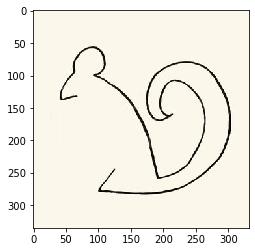

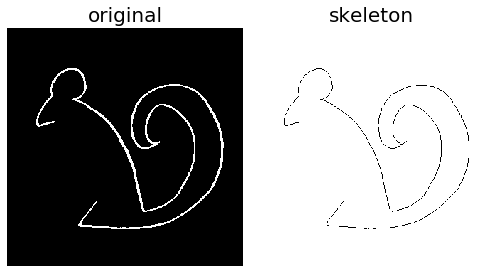

In [3]:
# Invert the squirrel image
squirrel = imageio.imread('images/squirrel.jpg') 
#print(squirrel.shape)
plt.imshow(squirrel)

squirrel_bw = invert(make_bw(squirrel))
skeleton = invert(thin(squirrel_bw))

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=FIGURE_SIZE,
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(squirrel_bw, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)
#print(skeleton[150])

fig.tight_layout()
plt.show()

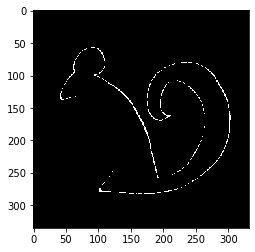

In [4]:
inverted_image = invert(make_bw(squirrel))
eroded_image = binary_erosion(inverted_image)

plt.imshow(eroded_image, cmap=plt.cm.gray)

(1, 3177, 2)


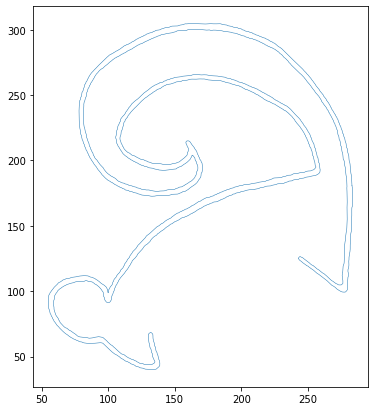

In [5]:
initial_image = imageio.imread("images/squirrel.jpg")
gray_scale_image = color.colorconv.rgb2grey(initial_image)
contours = measure.find_contours(gray_scale_image, 0.8)
# Now cast it to an NP array so it's more workable.
contours = np.array(contours)
print(contours.shape)

contour = contours[0]
xs = contour[:, 0]
ys = contour[:, 1]
plt.figure(figsize=(6, 7))
plt.plot(xs, ys,  linewidth=0.5)
plt.show()


def rotate_points(coordinate_pair):
    """
    Rotates the image reverse -90 degrees.
    """ 
    rotation_matrix = np.array([
        [0, 1],
        [-1, 0]
    ])
    result = np.matmul(rotation_matrix, coordinate_pair)
    return result

def translate_y(coordinate_pair):
    # TODO: these numbers are super hard-coded --- there's probably a simple way to make
    # This more programmatic by picking the most negative Y if there are negatives and 
    # translating it; And if all Y's are positive, bring them down
    result = [coordinate_pair[0], coordinate_pair[1] + 300]
    return result

# Do a reverse 90-degree matrix transformation on the points to rotate the image
contours = np.array([[rotate_points(cp) for cp in contours[0]]])
# And now move the points upwards by adding 300 to each point 
contours = np.array([[translate_y(cp) for cp in contours[0]]])

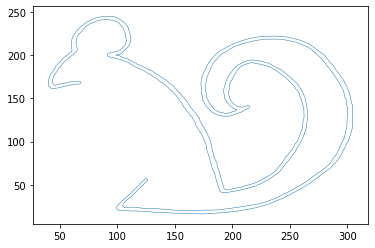

In [6]:
# Image once after the above matrix transformations have been applied:
contour = contours[0]
xs = contour[:, 0]
ys = contour[:, 1]
plt.plot(xs, ys,  linewidth=0.5)

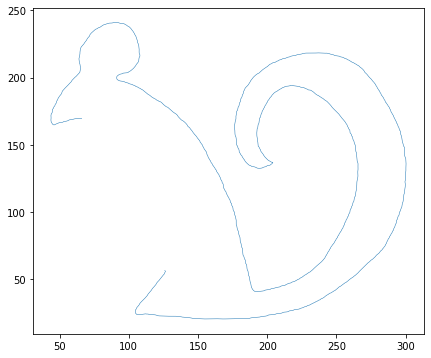

In [7]:
# Now, we must find the approximate 50% of the image to generate just one line; 
# since the vector starts and ends at the same point. This is a deeply manual process, 
# and if we had the extra time, perhaps we could find a way to automate this.
row_start = 1465
row_end = 3025

# Now, we can plot the image
# TODO: Get a figure at the normal size
plt.figure(figsize=(7, 6))

contour = contours[0]
xs = contour[row_start:row_end, 0]
ys = contour[row_start:row_end, 1]
plt.plot(xs, ys,  linewidth=0.5)

Text(0.5, 1.0, 'Squirrel, separated into line segments for interpolation')

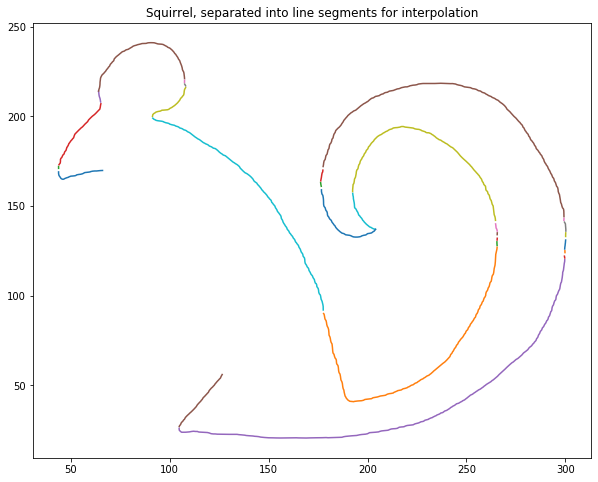

In [8]:
# Process so far: Use vectorization, grab roughly 50% of the line, since there's a start and end point
# Now that we have the continuous line traced, we'll run it through an algorithm to sectionize the line
line_contour = contours[0][row_start:row_end]

def extract_line_segments(line):
    """
    Extracts the line segments for vectorized contour lines such that there 
    are no overlapping Xs. Each of these line segments will be used for
    interpolating a spline. 
    
    Works by detecting the direction of the X, and every time it changes,
    it takes all data points starting at the last segment up until the current index
    to create a new segment, and then starts a new segment pair. 
    A positive direction is marked as True, whereas a decreasing X 
    is indicated as False.
    """
    all_segments = []

    for index, coordinate in enumerate(line):
        x, y = coordinate
        if index == 0:
            """
            Stick the initial two points into the segment array
            and get the first "prev_direction" (which will be the same 
            as the next on the initial run) to start the process.
            """
            segment_start = 0
            prev_direction = (x - line[1][0]) < 0
            previous_x = x
            continue
        direction = (x - previous_x) > 0

        if direction != prev_direction:
            all_segments.append(line[segment_start:index])
            segment_start = index
        previous_x = x
        prev_direction = direction
    return np.array(all_segments)

line_segments = extract_line_segments(line_contour)

plt.figure(figsize=(10, 8))
for line_segment in line_segments:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)

plt.title("Squirrel, separated into line segments for interpolation")

We now reduce the number of line segments for this drawing from 36 to 19 segments total


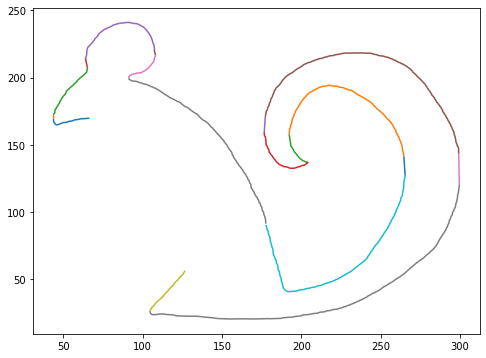

In [9]:
def handle_micro_segments(line_segments, threshold):
    """
    Detects a series of adjacent micro-segments and connects
    them into one larger segment for spline interpolation.
    
    Threshold indicates the number of points that a segment
    must fall under for it to be deemed "too small."
    """
    result = []
    aggregate_segment_indices = []
    aggregation_mode = False
    for index, segment in enumerate(line_segments):
        size = segment.shape[0]
        if size < threshold:
            if not aggregation_mode:
                aggregation_mode = True
                # Grab the first item of the small segment
                first_small_point = segment[0]
            else:
                # Keep grabbing segments
                continue
        else:
            # This means that we need to start small_segment 
            # over again because we saw a huge chunk
            # So, reset aggregation mode
            if aggregation_mode:
                # Save a bookmark to where the "aggregate" indices are
                aggregate_segment_indices.append(len(result))
                last_small_point = line_segments[index - 1][-1]
                # First small and last small should be points
                segment_of_small_points = np.array([first_small_point, last_small_point])
                result.append(segment_of_small_points)

            aggregation_mode = False
            result.append(segment)
    return (np.array(result), aggregate_segment_indices)
                

reduced_line_segments, aggregate_indices = handle_micro_segments(line_segments, 10)

# TODO: remove tiny segments, and maybe add a third point to any particularly vertical lines
# We can now also process the direction that the lines are going in, figure out the direction of the tiny segments
# And then append them to either end if possible

plt.figure(figsize=(8, 6))
for line_segment in reduced_line_segments:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)

print(f"We now reduce the number of line segments for this drawing from {len(line_segments)} to {len(reduced_line_segments)} segments total")

Further reduced the number of line segments from 19 to 14


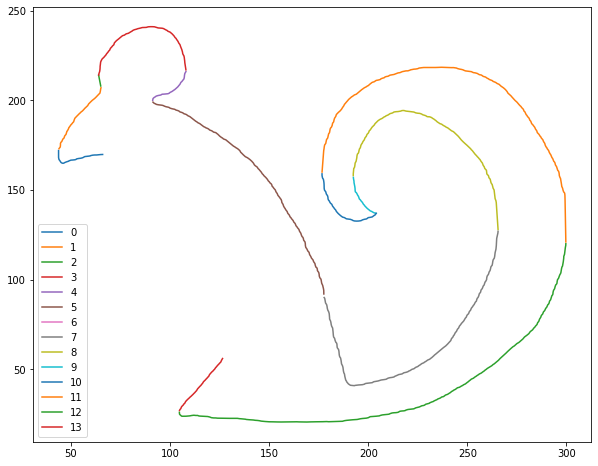

In [10]:

def attach_micro_segments_to_larger(line_segments, aggregate_segment_indices):
    """
    After running our line segments through extract_line_segments,
    our segments are guaranteed to go in one direction.
    
    We can take advantage of this property, to detect the direction
    of the mini line segments, and attach them to a neighboring larger one,
    such that we get even fewer "chunks."
    """
    result = []
    skip_next_iteration = False
    for index, line_segment in enumerate(line_segments):
        if index in aggregate_segment_indices:
            point_1, point_2 = line_segments[index]
            # Detect direction:
            direction = (point_2[0] - point_1[0]) > 0
            # Now, look at the direction of neighboring segments:
            
            # TODO: MAKE SURE THERE ARE NO LINE SEGMENTS EITHER END
            neighbor_1 = line_segments[index - 1]
            neighbor_2 = line_segments[index + 1]

            direction_neighbor_1 = (neighbor_1[1][0] - neighbor_1[0][0]) > 0
            direction_neighbor_2 = (neighbor_2[1][0] - neighbor_2[0][0]) > 0

            # Must always append the second point to the end of the first neighbor
            if direction == direction_neighbor_1:
                new_result = np.concatenate([result[-1], np.array([point_2])], axis=0)
                result[-1] = new_result

            # And the first point for the second neighbor on the right
            elif direction == direction_neighbor_2:
                new_segment = np.concatenate([np.array([point_1]), neighbor_2], axis=0)
                result.append(new_segment)
                skip_next_iteration = True
            else:
                result.append(line_segment)
        else:
            if skip_next_iteration:
                skip_next_iteration = False
            else:
                # If the segment is going in a different direction than either
                # neighbor, append it by itself.
                result.append(line_segment)
    return np.array(result)

final_segments = attach_micro_segments_to_larger(reduced_line_segments, aggregate_indices)

plt.figure(figsize=(10, 8))
for index, line_segment in enumerate(final_segments):
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys, label=index)
plt.legend()
    
print(f"Further reduced the number of line segments from {len(reduced_line_segments)} to {len(final_segments)}")

## ==============================
##  End of Emily's Code


## ==============================



## Interpolation Using Fourier Series



In [11]:
from symfit import parameters, variables, sin, cos, Fit
import numpy as np
import matplotlib.pyplot as plt

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

#credit: https://stackoverflow.com/questions/52524919/

In [12]:
for segments in final_segments:
    print(len(segments))

34
57
2
93
34
194
2
225
163
33
59
246
303
52


In [21]:
modified_final_segments =[]
def modify_segments(final_segments):
    for segment in final_segments:
        if(len(segment))>100:
            new_segment=[]
            for i in range(len(segment)):
                if i%10==0:
                    new_segment.append(segment[i])
            new_segment.append(segment[-1])
            modified_final_segments.append(new_segment)
        elif(len(segment))>30:
            new_segment=[]
            for i in range(len(segment)):
                if i%3==0:
                    new_segment.append(segment[i])
            new_segment.append(segment[-1])
            modified_final_segments.append(new_segment)
    
        else:
            modified_final_segments.append(segment)
    return modified_final_segments
    

In [23]:
modified_final_segments = modify_segments(final_segments)
modified_final_segments

[[array([ 66.       , 169.8039935]),
  array([ 63.        , 169.52529431]),
  array([ 60.        , 169.18078364]),
  array([ 58.        , 168.75515792]),
  array([ 55.98335625, 168.        ]),
  array([ 53.        , 167.37903759]),
  array([ 51.        , 166.72603755]),
  array([ 48.70558846, 166.        ]),
  array([ 46.43868542, 165.        ]),
  array([ 45.        , 165.35059921]),
  array([ 43.99301686, 167.        ]),
  array([ 43.77338474, 172.        ]),
  array([ 43.77338474, 172.        ])],
 [array([ 43.97251685, 173.        ]),
  array([ 44.72780154, 175.        ]),
  array([ 45.38080685, 177.        ]),
  array([ 46.53501628, 179.        ]),
  array([ 47.52251225, 181.        ]),
  array([ 48.23051897, 183.        ]),
  array([ 49.15752885, 185.        ]),
  array([ 50.56980836, 187.        ]),
  array([ 51.64282663, 189.        ]),
  array([ 52.83508291, 191.        ]),
  array([ 54.        , 192.30924191]),
  array([ 55.7144148, 194.       ]),
  array([ 57.        , 195.5

In [47]:

def fourier_interpolation(modified_final_segments,degree_coeff):
    coefficients = []
    plt.figure()
    plt.xlim(0,350)
    plt.ylim(0,350)
    for cut in modified_final_segments:
        x, y = variables('x, y')
        w, = parameters('w')
        degree =int(len(cut)/degree_coeff)
        if degree ==0: degree = 1
        model_dict = {y: fourier_series(x, f=w, n=degree)}
        xdata=[]
        ydata=[]
        for i in range(len(cut)):
            
            xdata.append(cut[i][0])
            ydata.append(cut[i][1])
    
        fit = Fit(model_dict, x=xdata, y=ydata)
        fit_result = fit.execute()
             
                
        xdata=np.array(xdata)
        
        plt.scatter(*zip(*cut), c = 'red', alpha = 0.5, s = 1)           
        plt.plot(xdata, fit.model(x=xdata, **fit_result.params).y, c="black")
        coefficients.append(fit_result.params)
    
    plt.savefig('results/degree_param_{}.png'.format(degree_coeff))
    return coefficients



C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot


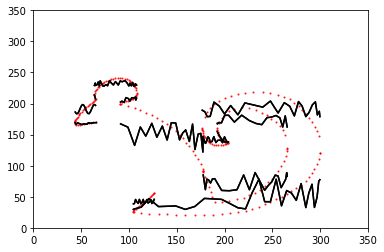

In [46]:
coefficients = fourier_interpolation(modified_final_segments, 32)

## Deriving an expression for the painting

In [48]:
final_exp_list =[]
for coef in coefficients:
    A=[None]*int(len(coef.items())/2)
    B=[None]*int(len(coef.items())/2)
    
    for key,value in  coef.items():
        if key[0]=='a':
            A[int(key[1:])]=value
        elif key[0]=='b':
            B[int(key[1:])]=value
        else:
            w=value
    expr_A= str(A[0])
    expr_B= ""
    ind_a = 1
    ind_b = 1
    for a_coeff in A[1:]:
        expr_A = expr_A +"+" + str(a_coeff) + "*sin({0}*{1}*t)".format(str(ind_a),w)
        ind_a+=1
    for b_coeff in B[1:]:
        expr_B = expr_B +"+" + str(b_coeff) + "*cos({0}*{1}*t)".format(str(ind_b),w)
        ind_b+=1
    final_exp = expr_A + expr_B
    final_exp_list.append(final_exp)

final_exp_list
    

['167.69255435564273+1.4112831153734098*sin(1*2.2745021723838*t)+-0.8924816130324545*cos(1*2.2745021723838*t)',
 '190.90851771695614+-0.24947036736208714*sin(1*-0.515997504730495*t)+-7.481290647654865*cos(1*-0.515997504730495*t)',
 '210.17236801844388+0.594989110966735*sin(1*1.0185349476054026*t)+5.958637368618302*cos(1*1.0185349476054026*t)',
 '232.4839381292921+1.9622331998872136*sin(1*-10.13243384612079*t)+4.005280612156617*cos(1*-10.13243384612079*t)',
 '206.3369966940773+-0.5624086726300067*sin(1*4.977637859623809*t)+-4.279540562104241*cos(1*4.977637859623809*t)',
 '145.11033821841062+-23.852757187646112*sin(1*6.765819843511503*t)+3.200586374915847*cos(1*6.765819843511503*t)',
 '60.14172670051742+21.878906452777528*sin(1*0.3592740053419036*t)+22.371661260296037*cos(1*0.3592740053419036*t)',
 '74.40166524158747+1.0604101450885532*sin(1*1.5239788812126733*t)+14.776321723762768*cos(1*1.5239788812126733*t)',
 '171.76827131190635+-7.140745749198064*sin(1*1.3941861758369507*t)+6.3435974

We have a length-N vector representation of the fourier series, when the length N represents the number of cuts we have created for making the initial segments. Now, using the 2π periodicity of the Fourier series of each segment, we can put each the segments into parameter ranges [0, 2π], [4π, 6π], [8π, 10π], …, whereas in the interleaving intervals (2π, 4π), (6π, 8π), …, we make the curve coordinates purely imaginary. Then, we obtain a piece-wise parametrized function representation of the trigonometric interpolation of the line drawing. 

## Degree = number of points/2

In [ ]:
fourier_interpolation(modified_final_segments, 2)

## Degree = number of points/4

C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - SS_res/SS_tot


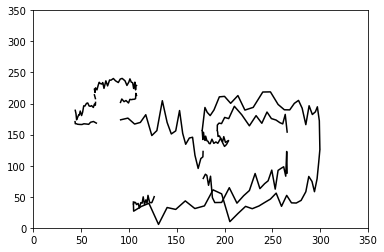

In [134]:
fourier_interpolation(modified_final_segments, 4)

## Degree = number of points/8

C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - SS_res/SS_tot


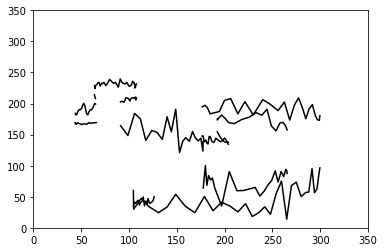

In [135]:
fourier_interpolation(modified_final_segments, 8)


## Degree = number of points/16

C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot


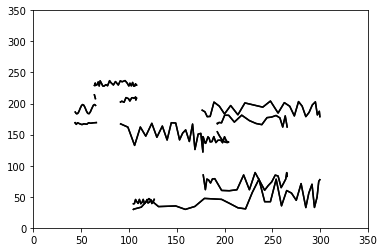

In [27]:
fourier_interpolation(modified_final_segments, 32)

C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - SS_res/SS_tot


--- 16168.813340187073 seconds ---


C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot


--- 2286.9832634925842 seconds ---


C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - SS_res/SS_tot


--- 416.66934967041016 seconds ---


C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot


--- 128.7447111606598 seconds ---


C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot


--- 26.416583776474 seconds ---


C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot


--- 12.070718050003052 seconds ---


C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot


--- 7.924913167953491 seconds ---


C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot
C:\TylerYoo\lib\site-packages\symfit\core\fit_results.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - SS_res/SS_tot


--- 7.077701091766357 seconds ---


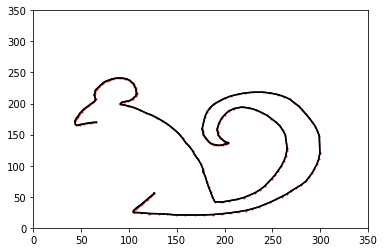

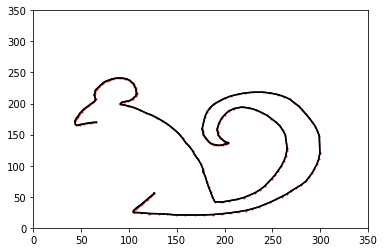

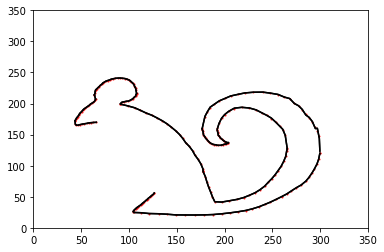

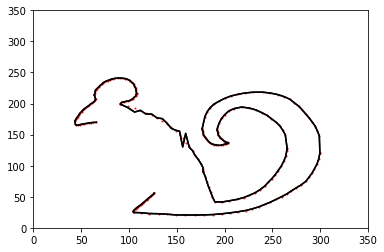

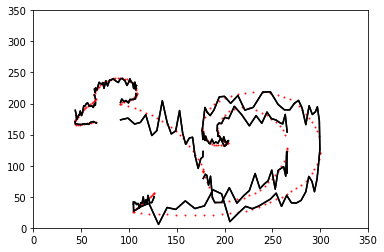

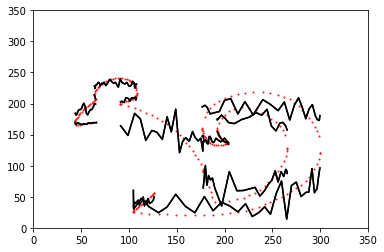

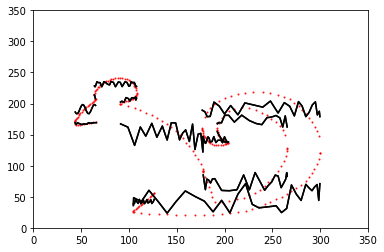

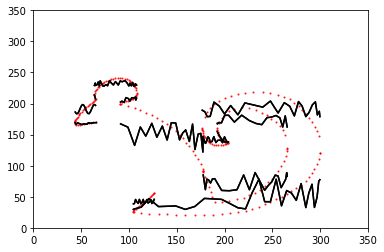

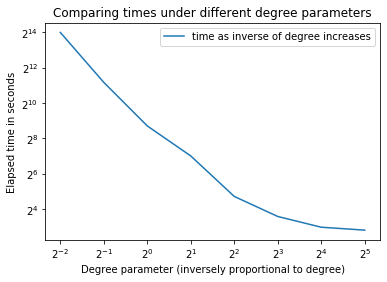

In [54]:
'''
Benchmark
'''

import time
import sys

times =[]
ninputs = [0.25,0.5,1,2,4,8,16,32]
for n in ninputs:
    start_time = time.time()
    fourier_interpolation(modified_final_segments, n)
    print("--- %s seconds ---" % (time.time() - start_time))
    times.append((time.time() - start_time))

# plot results

plt.figure()
plt.yscale('log', basey=2)
plt.xscale('log', basex=2)
plt.plot(ninputs, times, label='time as inverse of degree increases')
plt.legend()
plt.title('Comparing times under different degree parameters')
plt.xlabel('Degree parameter (inversely proportional to degree)')
plt.ylabel('Elapsed time in seconds')
plt.savefig('results/increasing_degree_param_32_to_0.25.png')